# Ejercicio 2

In [9]:
%matplotlib notebook

In [10]:
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm

# Visualización del proceso de aprendizaje en Regresión Lineal con descenso de gradiente

Funciones auxiliares (solo ejecutar, y seguir más abajo)

In [11]:
OptimizationState = namedtuple('OptimizationState', ['error_history','max_iterations'])
IterationState    = namedtuple('IterationState', ['iteration','m','b','dEdm', 'dEdb','yhat','errors','mean_error'])
OptimalModel      = namedtuple('Model', ['m', 'b','error'])

PlotState = namedtuple('PlotState', ['figure','axes','legends'])

## MODELO OPTIMO CON METODO ANALITICO DE SKLEARN
def optimal_model(x,y):
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x.reshape(-1, 1),y)
    optimal_m=regr.coef_[0]
    optimal_b=regr.intercept_
    optimal_yhat=x*optimal_m+optimal_b
    optimal_error=((optimal_yhat-y)**2).mean()
    return OptimalModel(optimal_m,optimal_b,optimal_error)
    
## FUNCIONES DE DIBUJO
def init_data(ax_data,x,y,optimal,m,b):
    ax_data.scatter(x,y,color="blue")
    
    x_pad=10
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    ax_data.plot([min_x,max_x],[min_x*optimal.m+optimal.b,max_x*optimal.m+optimal.b],color="cyan")
    ax_data.plot([min_x,max_x],[min_x*m+b,max_x*m+b],color="red")
    
    ax_data.set_xlabel("x (Horas estudiadas)")
    ax_data.set_ylabel("y (Nota)")
    
def init_error_history(ax_error):
    ax_error.set_xlabel("Iteración")
    ax_error.set_ylabel("Error")
    ax_error.set_title("Historial de Error")
    
def init_contour(ax_contour,x,y,optimal,m,b):    
    ax_contour.set_xlabel("m")
    ax_contour.set_ylabel("b")
#     ax3.set_zlabel("E")
    ax_contour.set_title("Contorno de E(m,b) ")
    detail=0.05
    param_range=8
    M = np.arange(-param_range, param_range, detail)
    B = np.arange(-param_range, param_range, detail)
    Ms, Bs = np.meshgrid(M, B)
    E=np.zeros_like(Ms)
    n=len(x)
    for i in range(n):
        Yi=Ms*x[i]+Bs
        E+=(Yi-y[i])**2
    E/=n

    surf=ax_contour.contourf(Ms,Bs,E,cmap='coolwarm')
    
    ax_contour.scatter([optimal.m], [optimal.b],c="green")
    plt.colorbar(surf, shrink=0.5, aspect=5)
    
def init_plot(x,y,optimal,m,b):
    
    figure=plt.figure(figsize=(12, 4),dpi=120)
    plt.suptitle('Entrenamiento de modelo lineal')
    ax_data=figure.add_subplot(1,3,1)
    ax_error=figure.add_subplot(1,3,2)
    ax_contour=figure.add_subplot(1,3,3)
    axes=(ax_data,ax_error,ax_contour)
    
    init_data(ax_data,x,y,optimal,m,b)
    init_error_history(ax_error)
    init_contour(ax_contour,x,y,optimal,m,b)
    plt.tight_layout()
    
    
    
    return PlotState(figure,axes,None)

def visualizar(plot_state,x,y,iteration_state,optimal,optimization_state):
    (ax1,ax2,ax3)=plot_state.axes
    # Visualizacion
    
    #actualizar linea del modelo actual
    ax1.lines.pop()
    x_pad=10
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    ax1.plot([min_x,max_x],[min_x*m+b,max_x*m+b],color="red")
#     ax3.scatter(iteration_state.m, iteration_state.b, iteration_state.mean_error,c="black",s=50)
    ax3.scatter([iteration_state.m], [iteration_state.b],c="black",s=5)
    
    # Mostrar leyendas
    model = patches.Patch(color='red', label='Modelo: y=x*({:.2f})+({:.2f})'.format(iteration_state.m,iteration_state.b))
    model_true = patches.Patch(color='cyan', label='Modelo óptimo: y=x*({:.2f})+({:.2f})'.format(optimal.m,optimal.b))
    label='$\\frac{ \\partial E}{\\partial m}=$ %.2f, $\\frac{ \\partial E}{\\partial b}$ %.2f' %(iteration_state.dEdm,iteration_state.dEdb)
    derivatives = patches.Patch(color='red', label=label)
    error_patch = patches.Patch(color='red', label='$E=\\frac{1}{n} \sum_i^n E_i=$ %.2f' % (iteration_state.mean_error))
    optimal_error = patches.Patch(color='cyan', label='E del modelo óptimo: %.2f' % (optimal.error))
    handles=[model,derivatives,error_patch,model_true,optimal_error]
    ax1.legend(handles=handles)
    
    ax2.lines.clear()
    ax2.plot(optimization_state.error_history,color="blue")
    ax2.set_xlim(0,optimization_state.max_iterations)
    ax1.set_title("Iteración %03d / %03d" % (iteration_state.iteration+1,optimization_state.max_iterations))
    plot_state.figure.canvas.draw()

# Carga de datos

In [12]:
dataset_base = ""
dataset      = "study_regression_small.csv"
#dataset="anscombe4.csv"

dataset_path = os.path.join(dataset_base,dataset)
data         = np.loadtxt(open(dataset_path, "rb"), delimiter=",", skiprows=1)
x,y          = data[:,0], data[:,1]

# Visualización del modelo y la superficie del error durante el aprendizaje

El siguiente código entrena un modelo de regresión lineal `f(x)=mx+b` con descenso de gradiente.

Para eso se muestran 3 gráficos durante la optimización:
* Los datos y el modelo, con los valores del error medio y las derivadas de los parámetros.
* La curva de error, que indica el error del modelo para cada iteración del algoritmo
* La superficie del error, que en este caso se muestra como el _contorno_ del error, es decir, como la superficie del error vista de arriba, y utilizando colores para indicar los valores del error.

Estos gráficos se actualizan en cada iteración del algoritmo, de modo de poder ver el recorrido de los valores `m` y `b`, como eso afecta al modelo, y como va minimizándose el error en consecuencia.

Probá modificando:
* Los valores iniciales de los parámetros `m` y `b`
* La tasa de aprendizaje `α`
* La cantidad de iteraciones máximas `max_iterations`

Y comprendiendo como estos valores inciden en el algoritmo. Respondé:

* ¿Qué valores de `α` permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?
  * **RE**: Cundo mas chi es alpha ma lento el entrenamiento y mas lenta la convergencia del error. Cuando mas grande Mas rapido convergue, pero validare dmaciado grande pueden hacer que el error diverja.
* ¿Se alcanza siempre el mínimo global (punto verde)?
  * **RE**: No nunca hata ahora.
* ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?
  * **RE**
      * Los parametros mas importantes son el numero de iteraciones y el lerning rate(alpha).
      * A medida que me acerco al minimo global el valor de las deribasdas se acerca mas a cero, ya que disminuche el valor de la pendiente de cada parametro.
* ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?
    * **RE**: No el avance depeden de la pendiente o valor de las derivadas en cada dimencion del error. Amedida que el optimizacor se acerca mas y mas a un minimo, la pendiente disminije y esto produce que el paso sea cada vez mas chico. En forma secundario el paso esta afecta do por alpha/learning rate. Es una foram de poder afectar al tamaño del paso mas alla que este depeden directamente del valor de la derivada o pendiente en cada punto de la superficie del error a evaluar.


Luego de eso, normalizá los datos de entrada `x` restándoles la media μ y dividiendo por la desviación estándar σ con la fórmula `x ← (x-μ)/σ`. Recordá que `x` es un vector de NumPy y por ende soporta los métodos `mean()` y `std()`. 

Volvé a responder las preguntas anteriores ahora con los datos normalizados.

* **RE**: Lo interesante, luego de normalizar, es que la superficie del error ahora es simetrica y el minimo global es el unico minimo. Antes de normalizar, la superficie tenia un valle minimo y esto ocasionaba que el algoritmo del gradiende descendente al llegar a este valle disminuyera el paso y nunca llegara al minimo global, o llegara pero necesitando aumentar el numero de itreaciones, o necesitar una estrategia para aumentar el learning rate al momento del llegar al valle para intentar llegar al minimo global. Todo esto se simplifico al normalizar las variables.

NORMALIZAR

In [13]:
x = (x - x.mean()) / x.std()

Parámetros iniciales del modelo (probar valores entre -5 y 5):

In [14]:
m = 5
b = -4

Configuración del descenso de gradiente:

In [15]:
#iteraciones máximas a realizar
max_iterations = 400

#velocidad de aprendizaje
#valores sensatos: entre 0.00001 y 0.001 (pero probar otros también!)
alpha = 0.005

fps = 5

Optimización con descenso de gradiente    

<IPython.core.display.Javascript object>


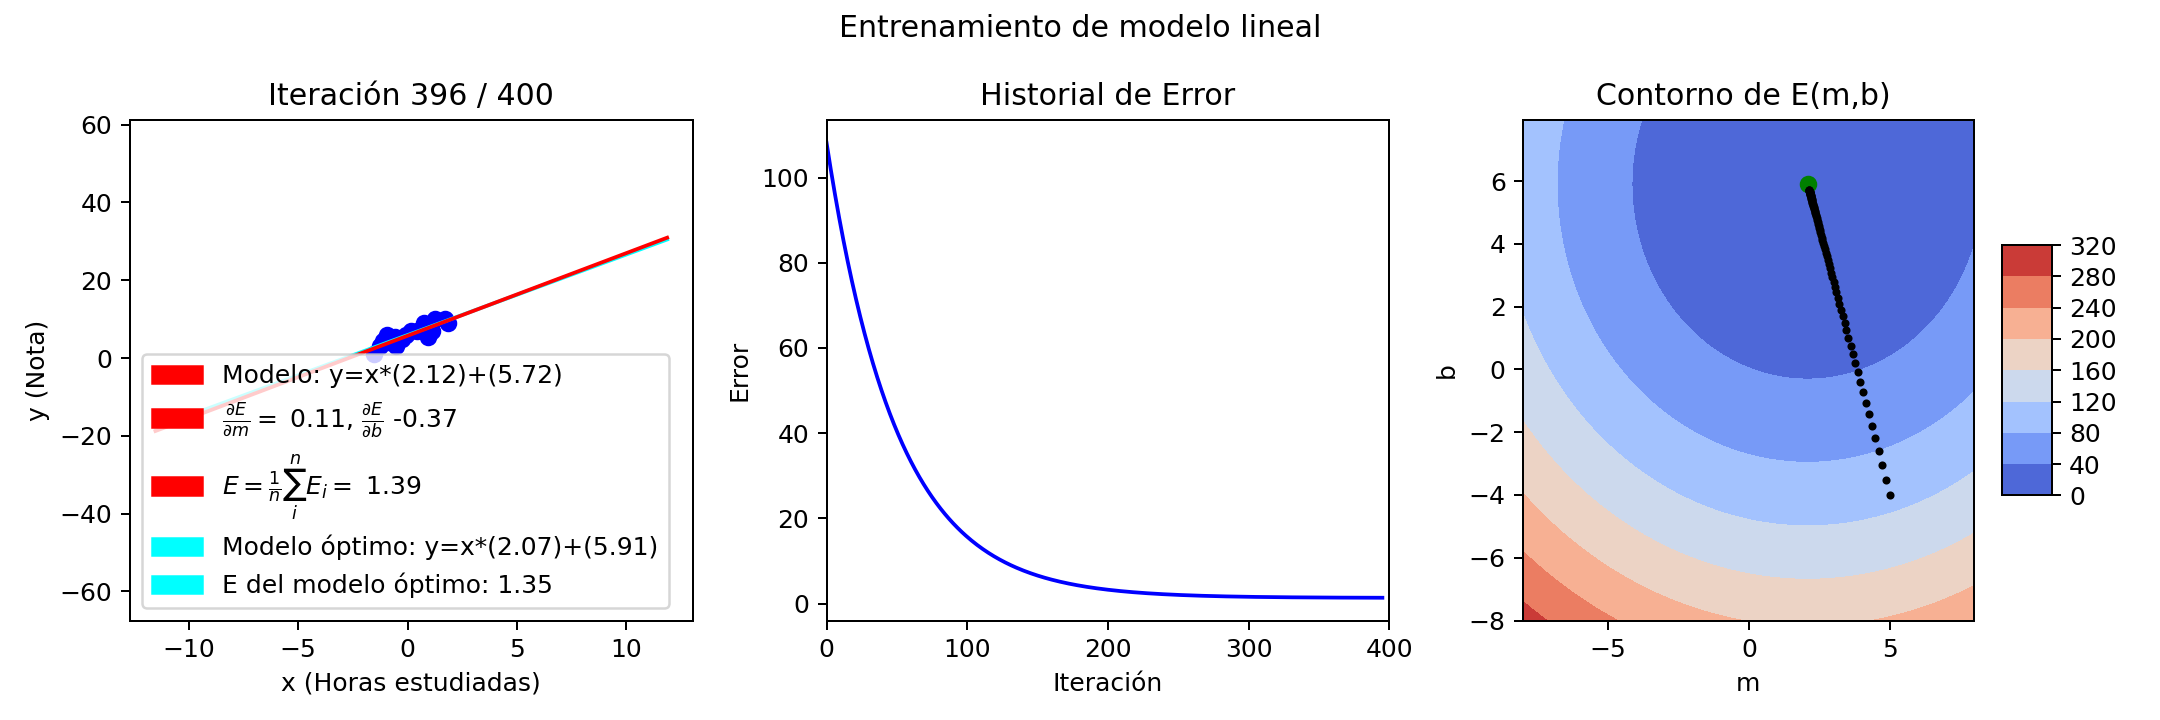

In [16]:
optimal       = optimal_model(x, y)
iteration     = 0

plot_state         = init_plot(x, y, optimal, m, b)
optimization_state = OptimizationState(
    max_iterations=max_iterations, 
    error_history=[]
)

while iteration < optimization_state.max_iterations:
    # Predicciones del modelo
    yhat = x * m + b

    # ERROR del modelo...
    errors = (y - yhat) ** 2 # Error de cada ejemplo Ei
    mean_error = errors.mean() # Error total E

    # Actualizar datos para plotear
    optimization_state.error_history.append(mean_error)
    
    # Calculo de derivadas (para usar luego en descenso de gradiente)
    dEdm = 2 * ((yhat - y) * x).mean()
    dEdb = 2 * (yhat  - y).mean()
    
    # Visualización cada 5 iteraciones (bajar 1 para que sea más frecuente)
    if (iteration % 5 == 0):
        iteration_state = IterationState(iteration, m, b, dEdm, dEdb, yhat, errors, mean_error)
        visualizar(plot_state, x, y, iteration_state, optimal, optimization_state)
        plt.pause(1/fps)
    iteration += 1

    # DESCENSO DE GRADIENTE
    m = m - alpha * dEdm # Actualizo m
    b = b - alpha * dEdb # Actualizo b
    # FIN DESCENSO DE GRADIENTE